In [ ]:
"""
Double-check trained melt
"""

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import cartopy
import cartopy.crs as ccrs
import matplotlib as mpl
import cmocean
import glob

In [9]:
home_path='/bettik/burgardc/'

In [2]:
param_classic_list = ['linear_local',
              'quadratic_local','quadratic_local_locslope',
              'lazero19',
              'boxes_4_pismyes_picopno']

param_NN_list = ['NNsmall']

In [20]:
## Melt outputpath
Gt_allmod_list = []
box1_allmod_list = []

for nemo_run in ['OPM006','OPM016','OPM018','OPM021','OPM031','ctrl94','isf94','isfru94']: #'CNRM-CM6-1',
    
    outputpath_melt = '/bettik/burgardc/DATA/SUMMER_PAPER/processed/OCEAN_MELT_RATE_CHECK_TUNING/nemo_5km_'+nemo_run+'/'

    melt1D_list = []
    for mparam in param_classic_list:
        melt1D_scenario = xr.open_dataset(outputpath_melt+'eval_metrics_1D_'+mparam+'_newtuning_oneFRIS.nc')
        melt1D_list.append(melt1D_scenario.assign_coords({'param':mparam}))
    melt1D_classic = xr.concat(melt1D_list, dim='param')       
    Gt_classic = melt1D_classic['melt_1D_Gt_per_y']

    
    if nemo_run in ['ctrl94','isf94','isfru94']:
        inputpath_profiles = '/bettik/burgardc/DATA/SUMMER_PAPER/interim/T_S_PROF/nemo_5km_'+nemo_run+'/'
        outputpath_melt = '/bettik/burgardc/DATA/SUMMER_PAPER/processed/OCEAN_MELT_RATE_TUNING/nemo_5km_'+nemo_run+'/'
    else:
        inputpath_profiles = '/bettik/burgardc/SCRIPTS/basal_melt_param/data/interim/T_S_PROF/nemo_5km_'+nemo_run+'/'
        outputpath_melt = '/bettik/burgardc/SCRIPTS/basal_melt_param/data/processed/MELT_RATE/nemo_5km_'+nemo_run+'/'
        
    melt1D_list = []
    for mparam in param_NN_list:
        melt1D_scenario = xr.open_dataset(outputpath_melt + 'evalmetrics_1D_small_newbasic2_extrap_normstd_newtuning.nc')
        melt1D_list.append(melt1D_scenario.assign_coords({'param':mparam}))
    melt1D_NN = xr.concat(melt1D_list, dim='param')   
    Gt_NN = melt1D_NN['predicted_melt'].sel(metrics='Gt')

    Gt_all = xr.concat([Gt_classic, Gt_NN], dim='param')
    
    Gt_allmod_list.append(Gt_all.assign_coords({'nemo_run': nemo_run}))

Gt_allmod = xr.concat(Gt_allmod_list, dim='nemo_run')


In [13]:
ref_Gt_list = []
ref_box1_list = []


run_list = ['OPM031','OPM021','OPM018','OPM016','OPM006','ctrl94','isf94','isfru94'] #'OPM026',
for n,nemo_run in enumerate(run_list):
    if nemo_run in ['ctrl94','isf94','isfru94']:
        outputpath_melt = home_path+'DATA/SUMMER_PAPER/processed/OCEAN_MELT_RATE_TUNING/nemo_5km_'+nemo_run+'/'
    else:
        outputpath_melt = home_path+'DATA/BASAL_MELT_PARAM/processed/MELT_RATE/nemo_5km_'+nemo_run+'/'
    NEMO_melt_rates_1D = xr.open_dataset(outputpath_melt+'melt_rates_1D_NEMO_oneFRIS.nc')
    ref_Gt = NEMO_melt_rates_1D['melt_Gt_per_y_tot']
    ref_Gt_list.append(ref_Gt.assign_coords({'nemo_run': nemo_run}))
    NEMO_box1_myr = xr.open_dataset(outputpath_melt+'melt_rates_box1_NEMO_oneFRIS.nc')
    ref_box1 = NEMO_box1_myr['mean_melt_box1_myr']
    ref_box1_list.append(ref_box1.assign_coords({'nemo_run': nemo_run}))
    
ref_Gt_all = xr.concat(ref_Gt_list, dim='nemo_run')
ref_box1_all = xr.concat(ref_box1_list, dim='nemo_run')

In [24]:
nrun='ctrl94'

  0%|          | 0/35 [00:00<?, ?it/s]

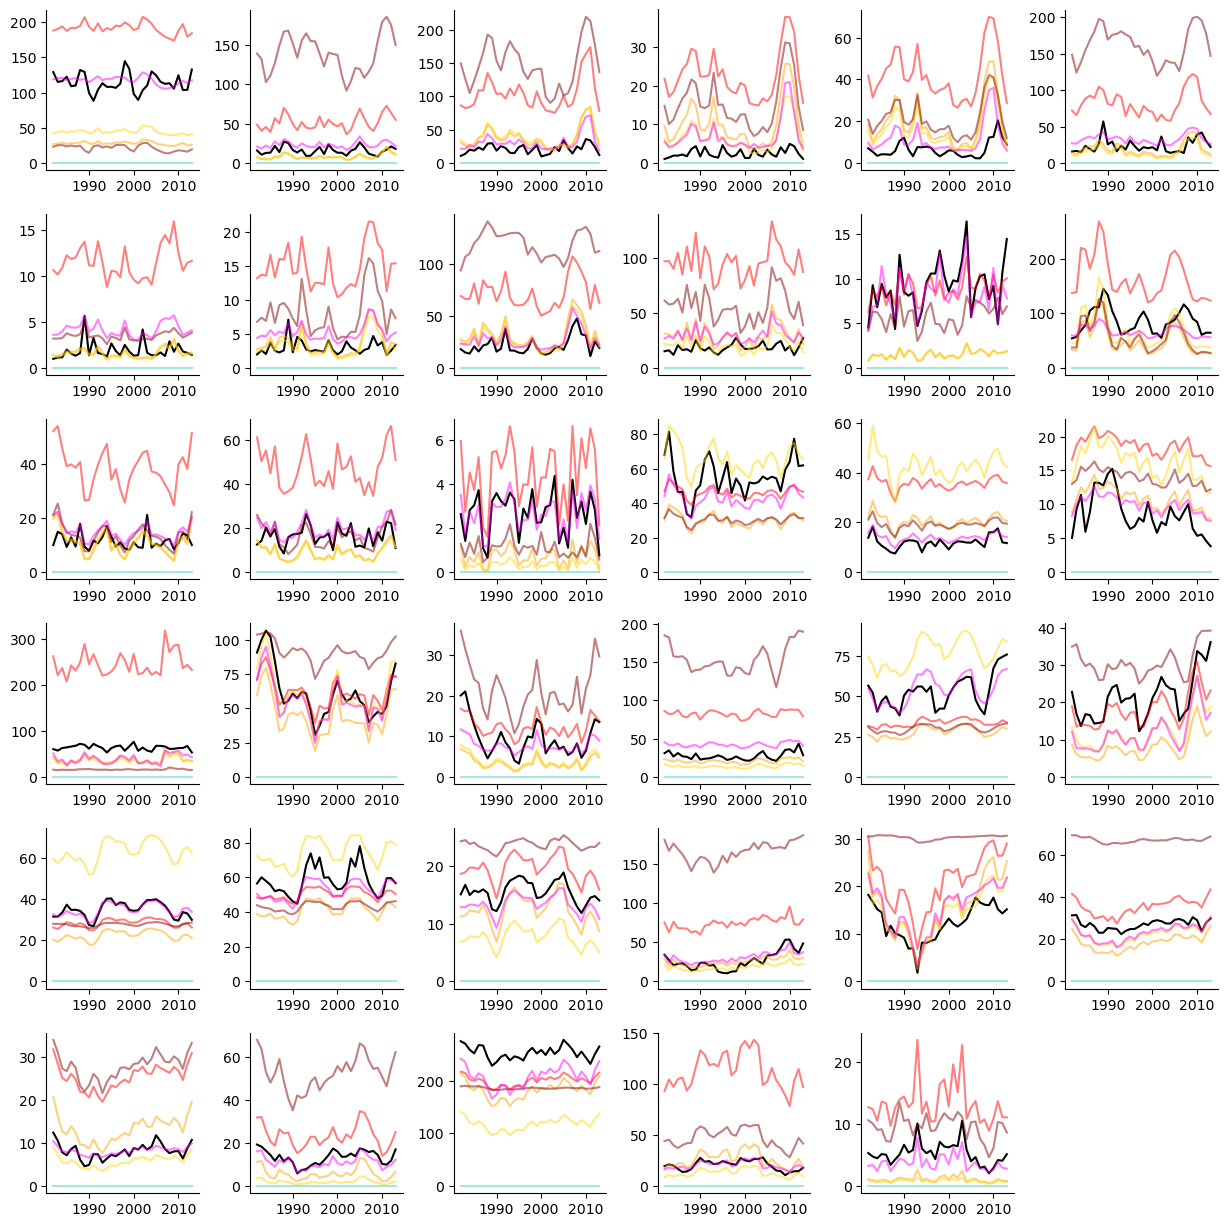

In [25]:
regions = ['Weddell','Bellingshausen','Amundsen','Ross','East 1','East 2','Dronning Maud Land']
colors = ['red','orange','gold','mediumturquoise','maroon','magenta','cornflowerblue','grey','yellowgreen']

f = plt.figure()
f.set_size_inches(8.25*1.5, 8.25*1.5)

ax={}

leg_hdl = []

i = 0

sorted_isf_all = [11,69,43,12,70,44,13,58,71,45,30,31,61,73,47,48,33,18,10,65,51,22,38,52,23,66,53,39,24,40,54,75,25,42,55]

plot_param = Gt_allmod.sel(nemo_run=nrun)
plot_ref = ref_Gt_all.sel(nemo_run=nrun)


for kisf in tqdm(sorted_isf_all):
    
    ax[i] = f.add_subplot(6,6,i+1)
    ax[i].plot(plot_param.time, plot_ref.sel(Nisf=kisf), color='k')

    
    for n,mparam in enumerate(plot_param.param):
        
        ax[i].plot(plot_param.time, plot_param.sel(param=mparam, Nisf=kisf), color=colors[n],alpha=0.5,label=mparam.values)


    #if kisf == 23:
    #    ax[i].set_title('Tracy Tremenchus')
    #elif kisf == 24:
    #    ax[i].set_title('Conger/Glenzer')
    #elif kisf == 110:
    #    ax[i].set_title('Ekström')
    #else:
    #ax[i].set_title(str(file_isf_orig['isf_name'].sel(Nisf=kisf).values))
    #ax[i].set_xlim(0,60)
    #ax[i].axvline(x=30, c='k', linestyle='--')

    i = i+1

#f.legend()
f.subplots_adjust(bottom=0.05, wspace=0.1)

f.tight_layout()
sns.despine()

In [19]:
Gt_allmod.nemo_run

<xarray.DataArray 'nemo_run' (nemo_run: 7)>
array(['OPM006', 'OPM016', 'OPM018', 'OPM021', 'ctrl94', 'isf94', 'isfru94'],
      dtype='<U7')
Coordinates:
    metrics     <U2 'Gt'
    box_nb_tot  int64 5
    config      int64 2
  * nemo_run    (nemo_run) <U7 'OPM006' 'OPM016' 'OPM018' ... 'isf94' 'isfru94'